# OBIA in Python

This notebook is support material for the blog post here: http://www.machinalis.com/blog/obia/

The code in the blog has been simplified so it may differ from what's done here.


In [1]:
import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

RASTER_DATA_FILE = "data/image/clip_2298119ene2016recorteTT.tif"
TRAIN_DATA_PATH = "data/train/"
TEST_DATA_PATH = "data/test/"

First, define some helper functions (taken from http://www.machinalis.com/blog/python-for-geospatial-data-processing/)

In [2]:

def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

In [57]:
import rasterio as rio

def arr2geotiff(arr, geotif_name: str):
    with rio.open(RASTER_DATA_FILE) as src:
        naip_data_ras = src.read()
        naip_meta = src.profile
        naip_meta['dtype'] = 'uint32'
        naip_meta['count'] = 1 # number of bands

    with rio.open(f'{geotif_name}.tif', 'w', **naip_meta) as dst:
        dst.write(arr.astype('uint32'), 1)

In [4]:
raster_dataset = gdal.Open(RASTER_DATA_FILE, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount
bands_data = []
for b in range(1, n_bands+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(b for b in bands_data)

<ipython-input-4-9df6674f8c92>:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  bands_data = np.dstack(b for b in bands_data)


Create images

In [120]:
img = exposure.rescale_intensity(bands_data).astype(np.float)
rgb_img = np.dstack([img[:, :, 3], img[:, :, 2], img[:, :, 1]])

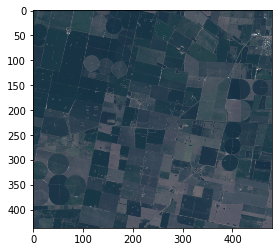

In [6]:
%matplotlib inline
plt.figure()
plt.imshow(rgb_img)

In [6]:
segments_quick = quickshift(img, kernel_size=10, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

2098


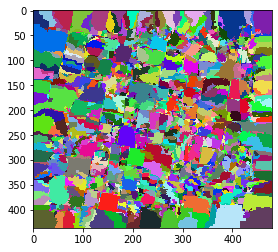

In [7]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
%matplotlib inline
plt.figure()
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

skimage.segmentation.felzenszwalb is not prepared to work with multi-band data. So, based on their own implementation for RGB images, I apply the segmentation in each band and then combine the results. See:
http://github.com/scikit-image/scikit-image/blob/v0.12.3/skimage/segmentation/_felzenszwalb.py#L69

In [164]:
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=85, sigma=0.25, min_size=9))

put pixels in same segment only if in the same segment in all bands. We do this by combining the band segmentation to one number

In [165]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

In [ ]:
n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
#SHOW_IMAGES:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segmentations')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segmentations')
plt.show()

In [95]:
# We choose the quick segmentation
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 14519 segments.


In [11]:
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

['data/train/E.shp', 'data/train/D.shp', 'data/train/B.shp', 'data/train/C.shp', 'data/train/A.shp']


In [12]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [13]:
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

4

In [16]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 2: 31
Training segments for class 3: 4
Training segments for class 4: 10
Training segments for class 5: 46


## Disambiguation
Check if there are segments which contain training pixels of different classes.

In [17]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

### ¡No need to disambiguate!

Next, we will _paint in black_ all segments that are not for training.
The training segments will be painted of a color depending on the class.

To do that we'll set as threshold the max segment id (max segments image pixel value). 
Then, to the training segments we'll assign values higher than the threshold.
Finally, we assign 0 (zero) to pixels with values equal or below the threshold.

In [167]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

### Lets see the training segments

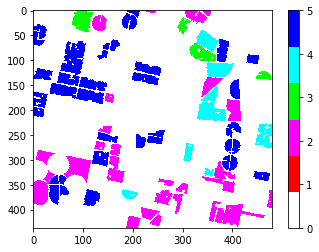

In [168]:
plt.figure()
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

# Training data

So now, we transform each training segment into a _segment model_ and thus creating the training dataset.

In [39]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features


### Create all the objects: 
compute the features' vector for each segment (and append the segment ID as reference)

In [222]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 14519 objects


### Subset the training data

https://mahotas.readthedocs.io/en/latest/labeled.html

In [189]:
num_labels = len(np.unique(segments_felz))
num_labels

14519

Number of labels: 14519


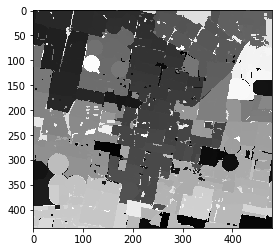

In [192]:
%matplotlib inline
print("Number of labels:", int(num_labels))
plt.imshow(segments_felz, cmap='gray')

In [195]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33535")
client

Client Scheduler: tcp://127.0.0.1:33535 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.25 GB


In [222]:
import dask_image.ndfilters
import dask_image.ndmeasure
import dask.array as da

combined_image = img[:,:,1]
label_image = segments_felz

index = list(range(int(num_labels)))  # Note that we're including the background label=0 here, too.
out_dtype = float  # The data type we want to use for our results.
default = None     # The value to return if an element of index does not exist in the label image.
mean_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.mean, out_dtype, default, pass_positions=False)
# area_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.area, out_dtype, default, pass_positions=False)
max_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.maximum, out_dtype, default, pass_positions=False)
min_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.minimum, out_dtype, default, pass_positions=False)
median_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.median, out_dtype, default, pass_positions=False)
std_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.standard_deviation, out_dtype, default, pass_positions=False)
sum_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.sum, out_dtype, default, pass_positions=False)
var_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.variance, out_dtype, default, pass_positions=False)

In [ ]:
import pandas as pd

%time
df = pd.DataFrame()
df['label'] = index
df['mean'] = mean_values.compute()
df['maximum'] = max_values.compute()
df['minimum'] = min_values.compute()
df['median'] = median_values.compute()
df['std'] = std_values.compute()
df['sum'] = sum_values.compute() 
df['variance'] = var_values.compute()

df.head()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
Exception in callback multi_future.<locals>.callback(<Task cancell...ient.py:1143>>) at /home/diogo/.ve/dask/lib/python3.8/site-packages/tornado/gen.py:495
handle: <Handle multi_future.<locals>.callback(<Task cancell...ient.py:1143>>) at /home/diogo/.ve/dask/lib/python3.8/site-packages/tornado/gen.py:495>
Traceback (most recent call last):
  File "/home/diogo/.pyenv/versions/3.8.1/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/diogo/.ve/dask/lib/python3.8/site-packages/tornado/gen.py", line 501, in callback
    result_list.append(f.result())
asyncio.exceptions.CancelledError


In [ ]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

# Train a classifier

In [224]:
classifier = RandomForestClassifier(n_jobs=-1)

In [225]:
classifier.fit(training_objects, training_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

# Classify all segments
Now we have to transform all segments into a _segment models_ in order to classify them

In [226]:
predicted = classifier.predict(objects)

# Propagate the classification
Now that each segment has been classified, we need to propagate that classification to the pixel level. That is, given the class **k** for the segment with label **S**, generate a classification from the segmented image where all pixels in segment **S** are assigned the class **k**.

In [227]:
clf = np.copy(segments)

In [228]:
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

Text(0.5, 1.0, 'Clasification')

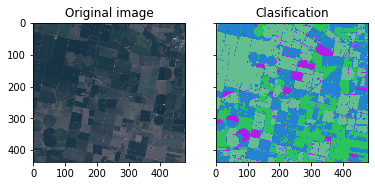

In [229]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)))
ax2.set_title('Clasification')

In [202]:
import rasterio as rio

dtype = 'int8'
with rio.open(RASTER_DATA_FILE) as src:
    naip_data_ras = src.read()
    naip_meta = src.profile
    naip_meta['dtype'] = dtype
    naip_meta['count'] = 1 # number of bands

# print(naip_meta)

with rio.open('combined_image1.tif', 'w', **naip_meta) as dst:
    dst.write(combined_image.astype(dtype), 1)

# Classification validation

In [169]:
shapefiles = [os.path.join(TEST_DATA_PATH, "%s.shp"%c) for c in classes_labels]
verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)

In [170]:
verification_labels = verification_pixels[for_verification]
predicted_labels = clf[for_verification]

In [171]:
cm = metrics.confusion_matrix(verification_labels, predicted_labels)

In [172]:
def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

In [ ]:
print_cm(cm, classes_labels)

In [149]:
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification accuracy: 1.000000


In [ ]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=classes_labels))